# Moteur de recherche pour le corpus d'articles scientifiques

In [1]:
# Imports des bibliothèques et modules nécessaires
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


# Ajouter le répertoire parent au chemin de recherche
sys.path.append(os.path.abspath('..'))

# Import des modules du projet
from src.config.config import load_config
from src.data_acquisition.data_loader import DataLoader
from src.search_engine.indexer import Indexer
from src.search_engine.ranking import RankingSystem

import warnings
warnings.filterwarnings("ignore")


## 1. Chargement des données prétraitées

In [2]:
# Chargement de la configuration 
config = load_config()

# Chemin vers le fichier de données
data_path = Path("../data/processed/corpus_preprocessed.json")

# Vérifier si le fichier existe
if not data_path.exists():
    raise FileNotFoundError(f"Le fichier {data_path} n'existe pas.")

# Créer un objet DataLoader
data_loader = DataLoader(config)

# Charger les données
cleaned_docs = data_loader.load_from_json(data_path)

# Afficher les premières lignes
pd.DataFrame(cleaned_docs).head()

,venue,abstract,authors,n_citation,references,title,year,id,class
0,international conference on human-computer int...,purpose study develop learning tool high schoo...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
1,international conference on human-computer int...,purpose study develop learning tool high schoo...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
2,visual analytics science and technology,paper describes design implementation methodol...,"[Gareth Beale, Graeme Earl]",50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
3,visual analytics science and technology,paper describes design implementation methodol...,"[Gareth Beale, Graeme Earl]",50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
4,pattern recognition and machine intelligence,article applied garch model instead ar arma mo...,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",50,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",2009,001c8744-73c4-4b04-9364-22d31a10dbf1,4


## 2. Construction de l'index

Nous allons maintenant construire un index inversé pour permettre la recherche efficace dans notre corpus. Cet index utilisera deux représentations vectorielles :
- TF (Term Frequency) : fréquence brute des termes
- TF-IDF (Term Frequency-Inverse Document Frequency) : pondération qui tient compte de la rareté des termes

In [3]:
# Créer un indexeur
indexer = Indexer(config)

# Construire l'index
content_field = 'processed_abstract' if 'processed_abstract' in cleaned_docs[0] else 'abstract'
print(f"Construction de l'index basé sur le champ '{content_field}'...")

# Ajuster les paramètres selon la taille du corpus
min_df = 2  # Apparaît dans au moins 2 documents
max_df = 0.8  # Apparaît dans maximum 80% des documents

indexer.build_index(
    cleaned_docs, 
    content_field=content_field, 
    id_field='id',
    min_df=min_df,
    max_df=max_df
)

# Afficher les statistiques de l'index
index_stats = indexer.get_index_stats()
print(f"\nIndex construit avec {index_stats['num_documents']} documents et {index_stats['vocabulary_size']} termes dans le vocabulaire")
print(f"Dimensions de la matrice TF-IDF : {index_stats['tfidf_matrix_shape']}")
print(f"Dimensions de la matrice TF : {index_stats['tf_matrix_shape']}")
print(f"Densité de la matrice TF-IDF : {index_stats['tfidf_density']:.2f}%")
print(f"Densité de la matrice TF : {index_stats['tf_density']:.2f}%")

Construction de l'index basé sur le champ 'abstract'...

Index construit avec 81192 documents et 71664 termes dans le vocabulaire
Dimensions de la matrice TF-IDF : (81192, 71664)
Dimensions de la matrice TF : (81192, 71664)
Densité de la matrice TF-IDF : 0.04%
Densité de la matrice TF : 0.04%


## 3. Analyse des termes les plus fréquents

Examinons les termes les plus fréquents dans notre corpus pour mieux comprendre son contenu.

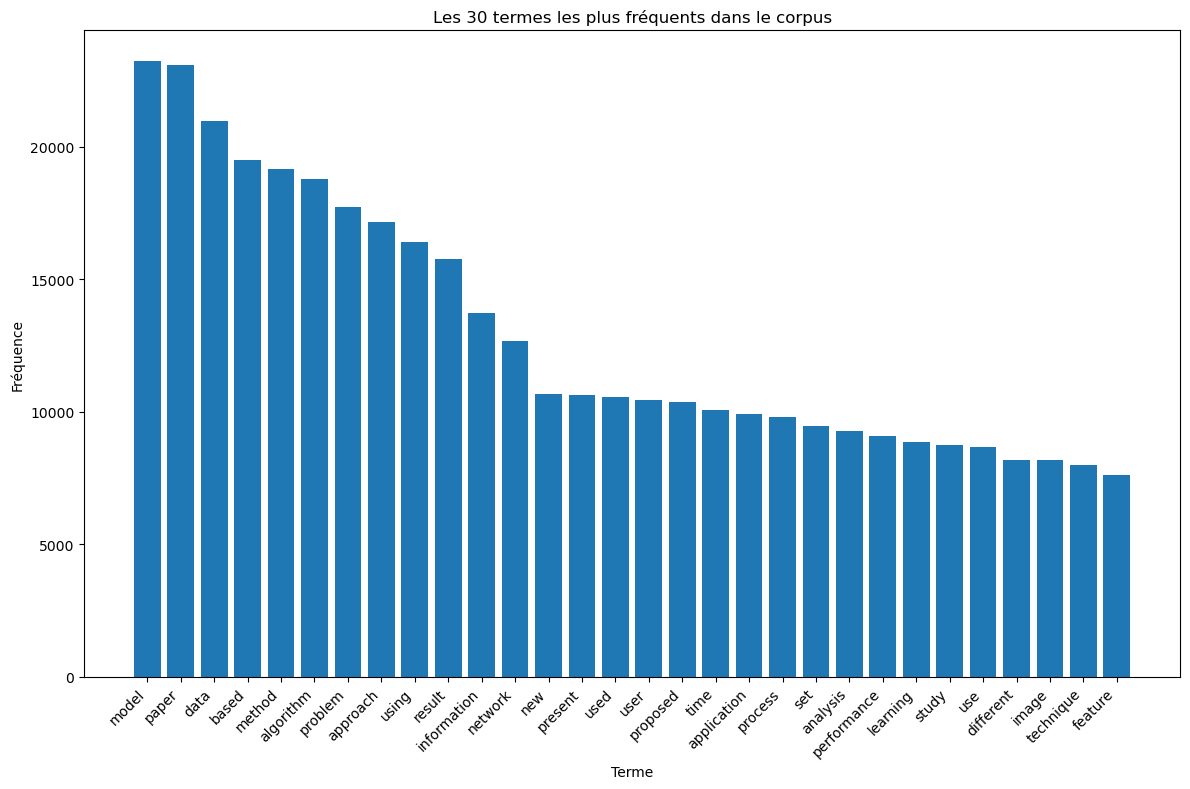

Top 30 des termes les plus fréquents :
- model: 23228
- paper: 23072
- data: 20952
- based: 19492
- method: 19150
- algorithm: 18798
- problem: 17734
- approach: 17160
- using: 16412
- result: 15780
- information: 13716
- network: 12672
- new: 10654
- present: 10614
- used: 10548
- user: 10438
- proposed: 10374
- time: 10052
- application: 9928
- process: 9818
- set: 9448
- analysis: 9288
- performance: 9100
- learning: 8856
- study: 8746
- use: 8678
- different: 8182
- image: 8164
- technique: 7990
- feature: 7632


In [4]:
# Obtenir les termes les plus fréquents
top_terms = indexer.get_term_frequencies(top_n=30)

# Visualiser les 30 termes les plus fréquents
plt.figure(figsize=(12, 8))
plt.bar(top_terms.keys(), top_terms.values())
plt.title('Les 30 termes les plus fréquents dans le corpus')
plt.xlabel('Terme')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Afficher les termes et leurs fréquences
print("Top 30 des termes les plus fréquents :")
for term, freq in sorted(top_terms.items(), key=lambda x: x[1], reverse=True):
    print(f"- {term}: {freq}")

## 4. Recherche simple



In [5]:
# Créer le système de classement
ranking_system = RankingSystem(indexer, cleaned_docs)

# Tester une requête simple
query = "machine learning"
print(f"Recherche pour la requête : '{query}'")

# Obtenir les résultats
results = ranking_system.search_with_text_query(query, top_n=5)

# Afficher les résultats
print(f"\nTop {len(results)} résultats :")
for i, result in enumerate(results):
    print(f"{i+1}. {result['title']} (Score: {result['score']:.4f})")
    print(f"   Auteurs: {', '.join(result['authors']) if isinstance(result['authors'], list) else result['authors']}")
    print(f"   Année: {result['year']}, Classe: {result['class']}")
    abstract = result.get('abstract', '')
    if abstract:
        print(f"   Abstract: {abstract[:150]}..." if len(abstract) > 150 else f"   Abstract: {abstract}")
    print()

Recherche pour la requête : 'machine learning'

Top 5 résultats :
1. Sparse Representation for Machine Learning (Score: 0.6206)
   Auteurs: Yifeng Li
   Année: 2013, Classe: 2

2. Sparse Representation for Machine Learning (Score: 0.6206)
   Auteurs: Yifeng Li
   Année: 2013, Classe: 2

3. Visual Data Mining and Machine Learning. (Score: 0.6045)
   Auteurs: Fabrice Rossi
   Année: 2006, Classe: 1

4. Visual Data Mining and Machine Learning. (Score: 0.6045)
   Auteurs: Fabrice Rossi
   Année: 2006, Classe: 1

5. Machine Learning and Relevance Feedback. (Score: 0.5753)
   Auteurs: Norbert Fuhr, Stephen Robertson
   Année: 1992, Classe: 1



## 5. Comparaison des méthodes de recherche

Comparer différentes configurations de recherche pour évaluer leur impact sur les résultats :
- TF vs TF-IDF : effet de la pondération sur la robustesse de la représentation
- Similarité cosinus vs distance euclidienne : Différentes mesures de similarité

In [7]:
# Comparer différentes méthodes de recherche
query = "deep learning neural networks"
print(f"Comparaison des méthodes de recherche pour la requête : '{query}'")

# Définir les combinaisons de méthodes à comparer
methods = {
    'tf_cosine': {"title": "TF + Cosinus", "use_tfidf": False, "similarity": "cosine"},
    'tfidf_cosine': {"title": "TF-IDF + Cosinus", "use_tfidf": True, "similarity": "cosine"},
    'tf_euclidean': {"title": "TF + Euclidienne", "use_tfidf": False, "similarity": "euclidean"},
    'tfidf_euclidean': {"title": "TF-IDF + Euclidienne", "use_tfidf": True, "similarity": "euclidean"}
}

# Obtenir les résultats pour chaque combinaison
results_by_method = {}
for method_key, params in methods.items():
    results_by_method[method_key] = ranking_system.search_with_text_query(
        query,
        top_n=3,
        use_tfidf=params["use_tfidf"],
        similarity_measure=params["similarity"]
    )

# Calculer les chevauchements entre méthodes
overlaps = {
    'pondération': set([r['id'] for r in results_by_method['tf_cosine']]) & 
                  set([r['id'] for r in results_by_method['tfidf_cosine']]),
    'similarité_tf': set([r['id'] for r in results_by_method['tf_cosine']]) & 
                    set([r['id'] for r in results_by_method['tf_euclidean']]),
    'similarité_tfidf': set([r['id'] for r in results_by_method['tfidf_cosine']]) & 
                       set([r['id'] for r in results_by_method['tfidf_euclidean']])
}

# Code (un peu long) pour afficher un tableau comparatif des résultats
print("\nCOMPARAISON DES COMBINAISONS DE MÉTHODES DE RECHERCHE")
print("=" * 70)

# Petite fonction d'affichage de texte tronqué
def truncate_text(text, max_length=30):
    return text[:max_length] + "..." if len(text) > max_length else text.ljust(max_length)

# Définir la largeur des colonnes pour un meilleur alignement
col_width = 35

# Afficher l'en-tête du tableau
headers = [methods[m]["title"] for m in methods]
print(f"{'Rang':<5} | {headers[0]:<{col_width}} | {headers[1]:<{col_width}} | {headers[2]:<{col_width}} | {headers[3]:<{col_width}}")
print("-" * (5 + 1 + 4 * (col_width + 3)))  # Ligne de séparation

# Préparer et afficher chaque ligne du tableau
for i in range(3):  # Pour les 3 premiers résultats
    # Initialiser la ligne avec le rang
    line = f"{i+1:<5} | "
    
    # Ajouter les informations pour chaque méthode
    for method_key in methods.keys():
        if i < len(results_by_method[method_key]):
            title = truncate_text(results_by_method[method_key][i]['title'], col_width - 20)
            score = results_by_method[method_key][i]['score']
            cell_content = f"{title} ({score:.4f})"
        else:
            cell_content = "--"
        line += f"{cell_content:<{col_width}} | "
    
    # Afficher la ligne (enlever le dernier '| ')
    print(line[:-2])

# Afficher les comparaisons
print("\nImpact des méthodes sur les résultats :")
print(f"1. Même mesure de similarité (cosinus), TF vs Tf-IDF : {len(overlaps['pondération'])} résultats communs sur 3")
print(f"2. Même représentation vectorielle (TF), similarité cosinus vs similarité distance euclidienne (1/(1+d)) : {len(overlaps['similarité_tf'])} résultats communs sur 3")
print(f"3. Même représentation vectorielle (TF-IDF), similarité cosinus vs similarité distance euclidienne (1/(1+d)) : {len(overlaps['similarité_tfidf'])} résultats communs sur 3")




Comparaison des méthodes de recherche pour la requête : 'deep learning neural networks'

COMPARAISON DES COMBINAISONS DE MÉTHODES DE RECHERCHE
Rang  | TF + Cosinus                        | TF-IDF + Cosinus                    | TF + Euclidienne                    | TF-IDF + Euclidienne               
--------------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Learning Dynami... (0.6708)         | Large Vocabular... (0.5612)         | Deep Learning o... (0.3660)         | Large Vocabular... (0.5163)         
2     | Learning Dynami... (0.6708)         | Large Vocabular... (0.5612)         | AdaBoost and ne... (0.3660)         | Large Vocabular... (0.5163)         
3     | AdaBoost and ne... (0.5774)         | Learning Dynami... (0.5213)         | Learning Dynami... (0.3660)         | Learning Dynami... (0.5054)         

Impact des méthodes sur les résultats :
1. Même mesure de simi

## 6. Recherche hybride (TF-IDF + Sémantique)

In [8]:
# Tester la recherche sémantique hybride (combinaison TF-IDF et embeddings)
print("\n=== RECHERCHE HYBRIDE (TF-IDF + SÉMANTIQUE) ===")
query = "deep learning for natural language processing"
print(f"Requête de test : '{query}'")

# Effectuer une recherche combinée (TF-IDF + sémantique)
results_combined = ranking_system.combine_ranking_methods(
    query,
    top_n=5,
    weights={'tfidf': 0.3, 'semantic': 0.7}  # Donner plus de poids aux embeddings sémantiques
)

# Afficher les résultats
print(f"\nTop {len(results_combined)} résultats (recherche hybride) :")
for i, result in enumerate(results_combined):
    print(f"{i+1}. {result['title']} (Score: {result['score']:.4f})")
    print(f"   Auteurs: {', '.join(result['authors']) if isinstance(result['authors'], list) else result['authors']}")
    print(f"   Année: {result['year']}, Classe: {result['class']}")
    print()

# Comparer avec une recherche TF-IDF standard
results_tfidf = ranking_system.search_with_text_query(query, top_n=5)

# Calculer le chevauchement
common_results = set([r['id'] for r in results_combined]) & set([r['id'] for r in results_tfidf])
print(f"\nChevauchement entre recherche hybride et TF-IDF : {len(common_results)} documents sur 5")

# Évaluer si les résultats sont différents
different_results = [r for r in results_combined if r['id'] not in [doc['id'] for doc in results_tfidf]]
if different_results:
    print("\nDocuments trouvés uniquement par la recherche hybride :")
    for i, result in enumerate(different_results):
        print(f"- {result['title']} (Score: {result['score']:.4f})")


=== RECHERCHE HYBRIDE (TF-IDF + SÉMANTIQUE) ===
Requête de test : 'deep learning for natural language processing'

Top 5 résultats (recherche hybride) :
1. Unsupervised Learning for Natural Language Processing. (Score: 1.0331)
   Auteurs: Daniel N. Klein
   Année: 2008, Classe: 1

2. Deep Learning of Representations (Score: 0.9599)
   Auteurs: Yoshua Bengio, Aaron C. Courville
   Année: 2013, Classe: 1

3. Optimizing initial configurations of neural networks for the task of natural language learning (Score: 0.8297)
   Auteurs: Jaime Jesus Davila
   Année: 1998, Classe: 1

4. Recurrent Greedy Parsing with Neural Networks (Score: 0.7780)
   Auteurs: Joël Legrand, Ronan Collobert
   Année: 2014, Classe: 2

5. Knowledge-Powered Deep Learning for Word Embedding (Score: 0.7619)
   Auteurs: Jiang Bian, Bin Gao, Tie-Yan Liu
   Année: 2014, Classe: 2


Chevauchement entre recherche hybride et TF-IDF : 2 documents sur 5

Documents trouvés uniquement par la recherche hybride :
- Optimizing initi

## 7. Analyse multi-requêtes

Analyse des résultats pour plusieurs requêtes représentatives de différents domaines, pour évaluer la cohérence du moteur de recherche et sa capacité à retourner des documents pertinents selon le sujet.

ANALYSE DES REQUÊTES PAR DOMAINE
                         Requête  Classe dominante  Score moyen
     machine learning algorithms                 1     0.463624
   neural networks deep learning                 1     0.547864
computer vision image processing                 8     0.584623
 natural language processing NLP                 1     0.510339
                network security                 5     0.531758
                     data mining                 6     0.921223
         graph theory algorithms                 5     0.561684


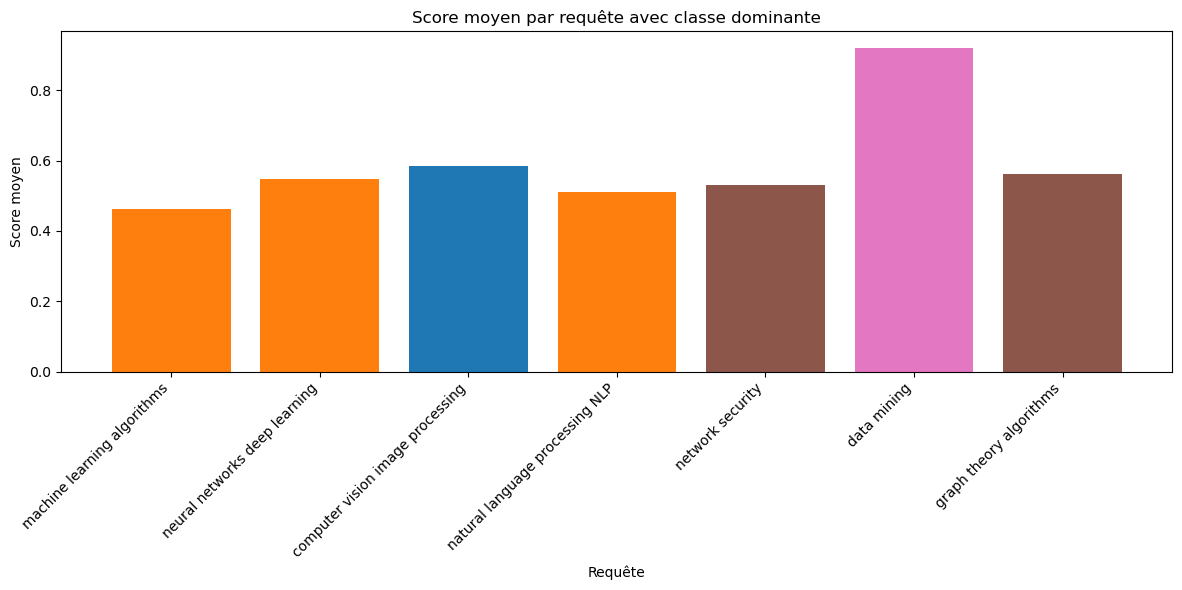


Correspondance des classes:
- Classe 1: Intelligence Artificielle
- Classe 2: Science des Données
- Classe 3: Interface
- Classe 4: Vision par Ordinateur
- Classe 5: Réseau
- Classe 6: Informatique Théorique
- Classe 7: Applications Spécifiques
- Classe 8: Autres

PERTINENCE PAR DOMAINE
Requête: 'machine learning algorithms'
Classe dominante: 1 (Intelligence Artificielle)
Cohérence avec le domaine: ✓
--------------------------------------------------
Requête: 'neural networks deep learning'
Classe dominante: 1 (Intelligence Artificielle)
Cohérence avec le domaine: ✓
--------------------------------------------------
Requête: 'computer vision image processing'
Classe dominante: 8 (Autres)
Cohérence avec le domaine: ✗
--------------------------------------------------
Requête: 'natural language processing NLP'
Classe dominante: 1 (Intelligence Artificielle)
Cohérence avec le domaine: ✓
--------------------------------------------------
Requête: 'network security'
Classe dominante: 5 (Ré

In [9]:
# Analyser plusieurs requêtes de test
test_queries = [
    "machine learning algorithms",
    "neural networks deep learning",
    "computer vision image processing",
    "natural language processing NLP",
    "network security",
    "data mining",
    "graph theory algorithms"
]

# Analyser chaque requête
analyses = {}
for query in test_queries:
    analyses[query] = ranking_system.analyze_query_results(query, top_n=3)

# Créer un DataFrame pour visualiser les résultats
analysis_df = pd.DataFrame({
    'Requête': test_queries,
    'Classe dominante': [analyses[q]['dominant_class'] for q in test_queries],
    'Score moyen': [analyses[q]['avg_score'] for q in test_queries],
    'Distribution des classes': [analyses[q]['class_distribution'] for q in test_queries]
})

# Afficher le tableau d'analyse
print("ANALYSE DES REQUÊTES PAR DOMAINE")
print("=" * 100)
print(analysis_df[['Requête', 'Classe dominante', 'Score moyen']].to_string(index=False))

# Visualiser la classe dominante pour chaque requête
plt.figure(figsize=(12, 6))
classes = [analyses[q]['dominant_class'] for q in test_queries]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
class_colors = [colors[c % len(colors)] if c is not None else '#cccccc' for c in classes]

plt.bar(test_queries, [analyses[q]['avg_score'] for q in test_queries], color=class_colors)
plt.title('Score moyen par requête avec classe dominante')
plt.xlabel('Requête')
plt.ylabel('Score moyen')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Afficher la correspondance des classes
class_descriptions = {
    1: "Intelligence Artificielle",
    2: "Science des Données",
    3: "Interface",
    4: "Vision par Ordinateur",
    5: "Réseau",
    6: "Informatique Théorique",
    7: "Applications Spécifiques",
    8: "Autres"
}

print("\nCorrespondance des classes:")
for cls, desc in class_descriptions.items():
    print(f"- Classe {cls}: {desc}")

# Analyse de la pertinence par domaine
print("\nPERTINENCE PAR DOMAINE")
print("=" * 50)

for query in test_queries:
    dominant_class = analyses[query]['dominant_class']
    class_name = class_descriptions.get(dominant_class, "Inconnue")
    
    # Vérifier si la requête et la classe dominante sont cohérentes
    expected_classes = {
        "machine learning": [1, 2],  # IA ou Science des données
        "neural networks": [1],      # IA
        "computer vision": [4],      # Vision par ordinateur
        "natural language": [1],     # IA
        "network security": [5],     # Réseau
        "data mining": [2],          # Science des données
        "graph theory": [5, 6]       # Réseau ou Informatique théorique
    }
    
    match = False
    for key, classes in expected_classes.items():
        if key in query.lower() and dominant_class in classes:
            match = True
            break
    
    print(f"Requête: '{query}'")
    print(f"Classe dominante: {dominant_class} ({class_name})")
    print(f"Cohérence avec le domaine: {'✓' if match else '✗'}")
    print("-" * 50)